# Compare Results of the Binary Python Model to the Original R Folds as in the paper

Plot the AUC of all 5 ensemble (only weights differ) of the split 6 from the paper (andrea).   
Compare the results to the original one achieved with R. Amongst others with a calibration plot.

## Load Libraries and Modules

In [99]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import random

from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import metrics
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model

print("TF  Version",tf.__version__)

TF  Version 2.2.0


In [100]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)

import functions_metrics as fm
import functions_model_definition as md

print("TF  Version",tf.__version__)

/tf/notebooks/schnemau/xAI_stroke_3d
TF  Version 2.2.0


## Load Data

In [109]:
# Define the path + output path:
print(os.getcwd())
IMG_DIR = "/tf/notebooks/hezo/stroke_perfusion/data/" 
# IMG_DIR2 = "/tf/notebooks/kook/data-sets/stroke-lh/"
DATA_DIR = "/tf/notebooks/hezo/stroke_perfusion/data/" 
WEIGHT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/weights/"




/tf/notebooks/schnemau/xAI_stroke_3d


In [110]:
model_name = "3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_sigmoid_activation_"
layer_connection = "globalAveragePooling"
last_activation = "sigmoid"

In [111]:
with h5py.File(IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5', "r") as h5:
# with h5py.File(IMG_DIR2 + 'dicom-3d.h5', "r") as h5:
# both images are the same
    X_in = h5["X"][:]
    Y_img = h5["Y_img"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]
    
X_in = np.expand_dims(X_in, axis = 4)
print(X_in.shape, X_in.min(), X_in.max(), X_in.mean(), X_in.std())

(439, 128, 128, 28, 1) -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0


In [112]:
dat = pd.read_csv(IMG_DIR + 'baseline_data_zurich_prepared.csv', sep=",")
dat

,p_id,mrs3,age,sexm,nihss_baseline,mrs_before,stroke_beforey,tia_beforey,ich_beforey,rf_hypertoniay,rf_diabetesy,rf_hypercholesterolemiay,rf_smokery,rf_atrial_fibrillationy,rf_chdy,eventtia
0,101,1,1.196256,-1.295848,0.645662,3.057795,-0.419507,-0.263596,-0.118205,0.712688,-0.448358,-1.237729,-0.556297,-0.460976,2.107803,0
1,103,0,-2.512593,-1.295848,-0.820817,-0.470965,-0.419507,-0.263596,-0.118205,-1.400370,-0.448358,-1.237729,-0.556297,-0.460976,-0.473492,0
2,104,0,1.025281,0.770174,-0.820817,-0.470965,-0.419507,-0.263596,-0.118205,-1.400370,2.225964,0.806338,-0.556297,-0.460976,-0.473492,0
3,105,6,1.432992,-1.295848,-0.820817,-0.470965,-0.419507,-0.263596,-0.118205,0.712688,-0.448358,0.806338,-0.556297,-0.460976,-0.473492,0
4,106,0,-0.539801,-1.295848,-0.820817,-0.470965,-0.419507,-0.263596,-0.118205,-1.400370,-0.448358,-1.237729,-0.556297,-0.460976,-0.473492,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,536,0,-1.473589,0.770174,-0.657875,-0.470965,-0.419507,-0.263596,-0.118205,0.712688,-0.448358,0.806338,1.794057,-0.460976,-0.473492,1
503,540,2,0.828002,-1.295848,0.319778,-0.470965,-0.419507,-0.263596,-0.118205,0.712688,-0.448358,0.806338,-0.556297,-0.460976,-0.473492,1
504,541,0,-3.183342,0.770174,0.808604,-0.470965,-0.419507,-0.263596,-0.118205,-1.400370,-0.448358,-1.237729,-0.556297,-0.460976,-0.473492,1
505,542,1,0.038885,0.770174,-0.331991,-0.470965,-0.419507,-0.263596,-0.118205,0.712688,2.225964,-1.237729,-0.556297,-0.460976,-0.473492,1


In [113]:
andrea_splits = pd.read_csv('/tf/notebooks/schnemau/xAI_stroke_3d/data/andrea_splits.csv', 
                            sep='\,', header = None, engine = 'python', 
                            usecols = [1,2,3]).apply(lambda x: x.str.replace(r"\"",""))
andrea_splits.columns = andrea_splits.iloc[0]
andrea_splits.drop(index=0, inplace=True)
andrea_splits = andrea_splits.astype({'idx': 'int32', 'spl': 'int32'})
split6 = andrea_splits.loc[andrea_splits['spl']==6]
split6

,idx,type,spl
2036,372,test,6
2037,284,test,6
2038,298,test,6
2039,203,test,6
2040,292,test,6
...,...,...,...
2438,403,train,6
2439,404,train,6
2440,405,train,6
2441,406,train,6


In [114]:
n = []
for p in pat:
    if p in dat.p_id.values:
        n.append(p)
n = len(n)

# match image and tabular data
X = np.zeros((n, X_in.shape[1], X_in.shape[2], X_in.shape[3], X_in.shape[4]))
X_tab = np.zeros((n, 13))
Y_mrs = np.zeros((n))
Y_eventtia = np.zeros((n))
p_id = np.zeros((n))

i = 0
for j, p in enumerate(pat):
    if p in dat.p_id.values:
        k = np.where(dat.p_id.values == p)[0]
        X_tab[i,:] = dat.loc[k,["age", "sexm", "nihss_baseline", "mrs_before",
                               "stroke_beforey", "tia_beforey", "ich_beforey", 
                               "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                               "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]]
        X[i] = X_in[j]
        p_id[i] = pat[j]
        Y_eventtia[i] = Y_pat[j]
        Y_mrs[i] = dat.loc[k, "mrs3"]
        i += 1
X_tab.shape

(407, 13)

In [115]:
Y_new = []
for element in Y_mrs:
    if element in [0,1,2]:
        Y_new.append(0)
    else:
        Y_new.append(1)
Y_new = np.array(Y_new)

In [116]:
# Split data into training set and test set "split6"

X = np.squeeze(X)
X = np.float32(X)

train_idx = split6["idx"][split6['type'] == "train"].to_numpy() -1 
valid_idx = split6["idx"][split6['type'] == "val"].to_numpy() - 1 
test_idx = split6["idx"][split6['type'] == "test"].to_numpy() - 1 

X_train = X[train_idx]
# y_train = Y_eventtia[train_idx]
y_train = Y_new[train_idx]
X_valid = X[valid_idx]
# y_valid = Y_eventtia[valid_idx]
y_valid = Y_new[valid_idx]
X_test = X[test_idx]
# y_test = Y_eventtia[test_idx]
y_test = Y_new[test_idx]

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(325, 128, 128, 28) (41, 128, 128, 28) (41, 128, 128, 28)
(325,) (41,) (41,)


## Model

In [117]:
input_dim = np.expand_dims(X_train, axis = -1).shape[1:]
output_dim = 1

# call model
model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.summary()


Model: "cnn_3d_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 28, 1)] 0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 128, 128, 28, 32)  896       
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 64, 64, 14, 32)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 64, 64, 14, 32)    27680     
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 32, 32, 7, 32)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 32, 32, 7, 64)     55360     
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 16, 16, 3, 64)     0   

In [118]:
model_3d.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

## Save Results per Model

Check first for one model:

In [120]:
model_3d.load_weights(WEIGHT_DIR + "andrea_split/" + model_name + "14" + ".h5")
# model_3d.evaluate(x=X_test, y=y_test)
# y_pred = model_3d.predict(X_test)

In [121]:
model_3d.evaluate(x=X_test, y=y_test)

2/2 [==============================] - 0s 14ms/step - loss: 0.3318 - acc: 0.8537 - auc_2: 0.8048


[0.33179089426994324, 0.8536585569381714, 0.8047618865966797]

Loop over all models and save the results.

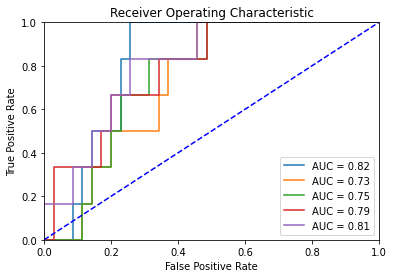

In [122]:
model_endings = ["10", "11", "12", "13", "14"]
y_preds = []
fprs = []
tprs = []
aucs = []
cal_plot_datas = []

# ROC-Curve
plt.title('Receiver Operating Characteristic')

for model_ending in model_endings:
    model_3d.load_weights(WEIGHT_DIR + "andrea_split/" + model_name + model_ending + ".h5")
    y_pred = model_3d.predict(X_test)
    y_preds.append(y_pred)
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, (y_pred))
    roc_auc = metrics.auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    
    cal_plot_datas.append(
        fm.cal_plot_data_prep(y_pred, y_test)
    )    

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Compare to Andrea

## Data Preparation

In [101]:
andrea_results_ens1 = pd.read_csv('/tf/notebooks/schnemau/xAI_stroke_3d/data/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl6_ens1.csv'
                            ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens2 = pd.read_csv('/tf/notebooks/schnemau/xAI_stroke_3d/data/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl6_ens2.csv'
                            ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens3 = pd.read_csv('/tf/notebooks/schnemau/xAI_stroke_3d/data/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl6_ens3.csv'
                            ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens4 = pd.read_csv('/tf/notebooks/schnemau/xAI_stroke_3d/data/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl6_ens4.csv'
                            ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens5 = pd.read_csv('/tf/notebooks/schnemau/xAI_stroke_3d/data/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl6_ens5.csv'
                            ).rename(columns={"Unnamed: 0": "p_idx"})

In [ ]:
## NOT NEEDED: same as above
# andrea_results_trafo = pd.read_csv('/tf/notebooks/brdd/xAI_stroke_3d/data/stroke_merged_bincdf_cimrsbinary.csv')
# andrea_results_trafo = andrea_results_trafo[
#     (andrea_results_trafo["loss"] == "nll") &
#     (andrea_results_trafo["type"] == "test") &
#     (andrea_results_trafo["spl"] == 6)]

In [102]:
andrea_calplot_dat_spl = pd.read_csv('/tf/notebooks/schnemau/xAI_stroke_3d/data/bincal_splnll.csv')
andrea_calplot_cibinary_spl = andrea_calplot_dat_spl[(andrea_calplot_dat_spl["mod"] == "cimrsbinary") &
                                                     (andrea_calplot_dat_spl["method"] == "trafo") &
                                                     (andrea_calplot_dat_spl["weights"] == "equal")]
andrea_calplot_cibinary_spl.head()

,Unnamed: 0,bin,prop,lwr,upr,cases,midpoint,spl,method,mod,weights
192,193,"[0,0.00786]",0.0,0.000000,0.284914,0.0,0.003932,1,trafo,cimrsbinary,equal
193,194,"(0.00786,0.0395]",0.1,0.002529,0.445016,1.0,0.023686,1,trafo,cimrsbinary,equal
194,195,"(0.0395,0.0872]",0.1,0.002529,0.445016,1.0,0.063358,1,trafo,cimrsbinary,equal
195,196,"(0.0872,1]",0.2,0.025211,0.556095,2.0,0.543603,1,trafo,cimrsbinary,equal
196,197,"[0,0.0861]",0.0,0.000000,0.284914,0.0,0.043045,2,trafo,cimrsbinary,equal


In [104]:
andrea_calplot_dat = pd.read_csv('/tf/notebooks/schnemau/xAI_stroke_3d/data/bincal_avgnll.csv')
andrea_calplot_cibinary_avg = andrea_calplot_dat[(andrea_calplot_dat["mod"] == "cimrsbinary") &
                                                 (andrea_calplot_dat["method"] == "trafo") &
                                                 (andrea_calplot_dat["weights"] == "equal")]
andrea_calplot_cibinary_avg
# cal_plot(andrea_calplot_cibinary_avg, "midpoint", "prop", "lwr", "upr")

,Unnamed: 0,bin,prop,lwr,upr,cases,midpoint,method,mod,weights
108,109,NaN,0.030303,0.000766,0.327536,0.333333,0.024017,trafo,cimrsbinary,equal
109,110,NaN,0.083333,0.005466,0.418023,0.833333,0.062701,trafo,cimrsbinary,equal
110,111,NaN,0.250000,0.053544,0.598091,2.500000,0.109624,trafo,cimrsbinary,equal
111,112,NaN,0.266667,0.058252,0.616015,2.666667,0.570940,trafo,cimrsbinary,equal


In [123]:
# fake trafo and linear averaging of results on split 6
y_preds = np.concatenate(y_preds, axis = 1)
y_pred_linear_avg = np.mean(y_preds, axis = 1)
y_pred_trafo_avg = fm.sigmoid(np.mean(fm.inverse_sigmoid(y_preds), axis = 1))

In [124]:
# calculate calibration plots
cal_plot_linear = fm.cal_plot_data_prep(y_pred_linear_avg, y_test)
cal_plot_trafo = fm.cal_plot_data_prep(y_pred_trafo_avg, y_test)

In [125]:
results = pd.DataFrame(
    {"p_idx": test_idx+1,
     "p_id": p_id[test_idx],
     "mrs": Y_mrs[test_idx],
     "unfavorable": y_test,
     "pred_prob_1": y_preds[:,0], 
     "pred_prob_2": y_preds[:,1], 
     "pred_prob_3": y_preds[:,2], 
     "pred_prob_4": y_preds[:,3], 
     "pred_prob_5": y_preds[:,4], 
     "pred_prob_linear" : y_pred_linear_avg,
     "pred_prob_trafo" : y_pred_trafo_avg,
     "andrea_pred_prob_ens1": 1-andrea_results_ens1["V2"],
     "andrea_pred_prob_ens2": 1-andrea_results_ens2["V2"],
     "andrea_pred_prob_ens3": 1-andrea_results_ens3["V2"],
     "andrea_pred_prob_ens4": 1-andrea_results_ens4["V2"],
     "andrea_pred_prob_ens5": 1-andrea_results_ens5["V2"]
    }
)
results.head()

,p_idx,p_id,mrs,unfavorable,pred_prob_1,pred_prob_2,pred_prob_3,pred_prob_4,pred_prob_5,pred_prob_linear,pred_prob_trafo,andrea_pred_prob_ens1,andrea_pred_prob_ens2,andrea_pred_prob_ens3,andrea_pred_prob_ens4,andrea_pred_prob_ens5
0,372,516.0,1.0,0,0.033087,0.035890,0.021814,0.036607,0.015162,0.028512,0.027053,0.016478,0.014460,0.012915,0.030665,0.024977
1,284,376.0,2.0,0,0.054752,0.048233,0.030962,0.065938,0.036211,0.047219,0.045592,0.042760,0.025574,0.018084,0.042981,0.072614
2,298,390.0,2.0,0,0.177525,0.136966,0.088634,0.262726,0.216284,0.176427,0.167321,0.059779,0.066379,0.081333,0.069178,0.073458
3,203,286.0,0.0,0,0.299940,0.187881,0.112556,0.181888,0.159077,0.188268,0.181086,0.254392,0.112507,0.291880,0.244444,0.258643
4,292,384.0,0.0,0,0.023283,0.024699,0.015666,0.035768,0.012427,0.022369,0.020949,0.003612,0.003291,0.002851,0.011365,0.012432


In [126]:
# do fake trafo averaging of andreas results
results["andrea_pred_prob_trafo"] = fm.sigmoid(np.mean(fm.inverse_sigmoid(results[
    ["andrea_pred_prob_ens1", "andrea_pred_prob_ens2", "andrea_pred_prob_ens3", "andrea_pred_prob_ens4", "andrea_pred_prob_ens5"]
    ]), axis = 1))
andrea_calplot_spl6_new = fm.cal_plot_data_prep(results["andrea_pred_prob_trafo"], y_test)

In [127]:
andrea_calplot_spl6_new

,predicted_probability_mean,predicted_probability_middle,observed_proportion,observed_proportion_lower,observed_proportion_upper,observed_cases,bin_cuts
0,0.011203,0.018155,0.000000,0.000000,0.277533,0,[0. 0.0363]
1,0.059238,0.065414,0.100000,0.017876,0.404150,1,[0.0363 0.0945]
2,0.140413,0.158823,0.100000,0.017876,0.404150,1,[0.0945 0.2231]
3,0.299310,0.611563,0.363636,0.151665,0.646199,4,[0.2231 1. ]


## Results of Ensemble

In [128]:
# Results Andrea
fm.calc_metrics(results["unfavorable"], results["andrea_pred_prob_trafo"])


Performance on Test Set : 
Accuracy: 0.8537
Area under Curve (AUC) Binary : 0.5
Area under Curve (AUC) Probability : 0.7619
Negative Log-Likelihood : 0.3618
Confusion Matrix : 
 [[35  0]
 [ 6  0]]


In [129]:
 # Results Python 
fm.calc_metrics(results["unfavorable"], results["pred_prob_trafo"])


Performance on Test Set : 
Accuracy: 0.8537
Area under Curve (AUC) Binary : 0.5
Area under Curve (AUC) Probability : 0.819
Negative Log-Likelihood : 0.345
Confusion Matrix : 
 [[35  0]
 [ 6  0]]


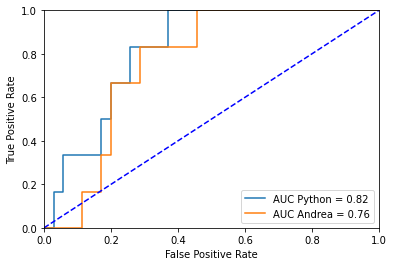

In [130]:
# Plot AUC of Python and Andrea's results
fpr, tpr, threshold = metrics.roc_curve(results["unfavorable"], results["pred_prob_trafo"])
roc_auc = metrics.auc(fpr, tpr)  
plt.plot(fpr, tpr, label = 'AUC Python = %0.2f' % roc_auc)
fpr, tpr, threshold = metrics.roc_curve(results["unfavorable"], results["andrea_pred_prob_trafo"])
roc_auc = metrics.auc(fpr, tpr)  
plt.plot(fpr, tpr, label = 'AUC Andrea = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [131]:
threshold

array([1.45264093, 0.45264093, 0.35237278, 0.30734543, 0.24994242,
       0.23467146, 0.22414097, 0.22312551, 0.16462666, 0.14431584,
       0.09451965, 0.08808498, 0.00254905])

## Calibration Plots

In [132]:
#!pip install seaborn
import seaborn as sns

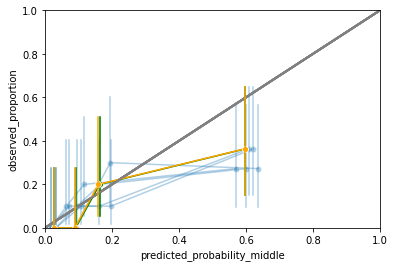

In [133]:
# calplot of each ensemble with linear (green) and trafo (orange) averaged for split 6
for i in range(5):
    fm.cal_plot(cal_plot_datas[i], 
             "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper", alpha = .35, show = False)
fm.cal_plot(cal_plot_linear, "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper", col = "green", show = False)
# # additionaly in blue averaged over all calplots
# fm.cal_plot(sum(cal_plot_datas)/5, "predicted_probability_middle", "observed_proportion",
#                         "observed_proportion_lower", "observed_proportion_upper", col = "blue", show = False)
fm.cal_plot(cal_plot_trafo, "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper", col = "orange")

In [134]:
andrea_calplot_cibinary_spl["bin_num"] = np.array(list(range(4))*6)
andrea_calplot_cibinary_spl_avg = andrea_calplot_cibinary_spl.groupby("bin_num")[["prop", "lwr", "upr", "midpoint"]].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


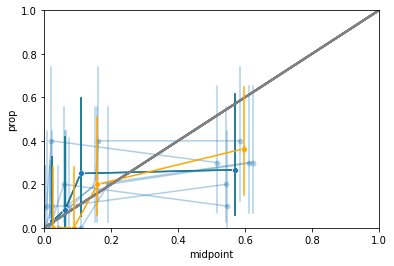

In [135]:
# plot as is in paper: per split (already trafo over each split) and averaged
# in green averaged directly shouldn't be visible as it should be same as the blue one
# in orange trafo averaged of own implementation of split 6
for i in range(6):
    fm.cal_plot(andrea_calplot_cibinary_spl[andrea_calplot_cibinary_spl["spl"] == i+1], 
             "midpoint", "prop", "lwr", "upr", alpha = .35, show = False)
fm.cal_plot(andrea_calplot_cibinary_spl_avg, "midpoint", "prop", "lwr", "upr", col = "green", show = False)
fm.cal_plot(andrea_calplot_cibinary_avg, "midpoint", "prop", "lwr", "upr", show = False)

fm.cal_plot(cal_plot_trafo, "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper", col = "orange")

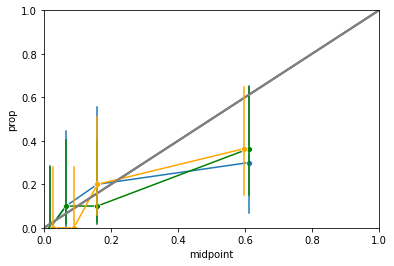

In [136]:
# cal plot comparision of split 6 
# blue: andrea original
# green: andrea calculated numbers based on results on each ensemble, trafo averaged
# orange: own implementation, trafo averaged
# -------------------------------
# green and blue should be same
fm.cal_plot(andrea_calplot_cibinary_spl[andrea_calplot_cibinary_spl["spl"] == 6], 
             "midpoint", "prop", "lwr", "upr", show = False)
fm.cal_plot(andrea_calplot_spl6_new, 
         "predicted_probability_middle", "observed_proportion", "observed_proportion_lower", "observed_proportion_upper", 
         col = "green", show = False)
fm.cal_plot(cal_plot_trafo, 
         "predicted_probability_middle", "observed_proportion", "observed_proportion_lower", "observed_proportion_upper", 
         col = "orange")


In [137]:
andrea_calplot_spl6_new

,predicted_probability_mean,predicted_probability_middle,observed_proportion,observed_proportion_lower,observed_proportion_upper,observed_cases,bin_cuts
0,0.011203,0.018155,0.000000,0.000000,0.277533,0,[0. 0.0363]
1,0.059238,0.065414,0.100000,0.017876,0.404150,1,[0.0363 0.0945]
2,0.140413,0.158823,0.100000,0.017876,0.404150,1,[0.0945 0.2231]
3,0.299310,0.611563,0.363636,0.151665,0.646199,4,[0.2231 1. ]


In [138]:
andrea_calplot_cibinary_spl[andrea_calplot_cibinary_spl["spl"] == 6]

,Unnamed: 0,bin,prop,lwr,upr,cases,midpoint,spl,method,mod,weights,bin_num
212,213,"[0,0.0363]",0.0,0.000000,0.284914,0.0,0.018155,6,trafo,cimrsbinary,equal,0
213,214,"(0.0363,0.0945]",0.1,0.002529,0.445016,1.0,0.065414,6,trafo,cimrsbinary,equal,1
214,215,"(0.0945,0.223]",0.2,0.025211,0.556095,2.0,0.158823,6,trafo,cimrsbinary,equal,2
215,216,"(0.223,1]",0.3,0.066740,0.652453,3.0,0.611563,6,trafo,cimrsbinary,equal,3


## Patient Comparison

Multiple scatter plots with different comparison methods

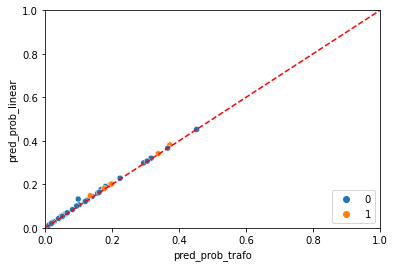

In [139]:
g = sns.scatterplot(data=results, x="pred_prob_trafo", y="pred_prob_linear", hue = "unfavorable")
plt.legend(loc='lower right')
g.set(ylim=(0, 1), xlim=(0,1))
g.plot([0,1], [0,1], "r--")

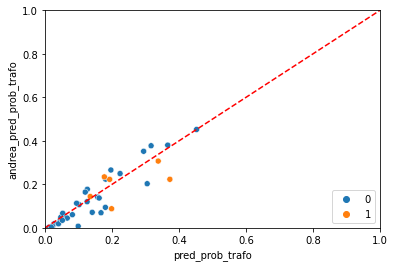

In [140]:
g = sns.scatterplot(data=results, x="pred_prob_trafo", y="andrea_pred_prob_trafo", hue = "unfavorable")
plt.legend(loc='lower right')
g.set(ylim=(0, 1), xlim=(0,1))
g.plot([0,1], [0,1], "r--")

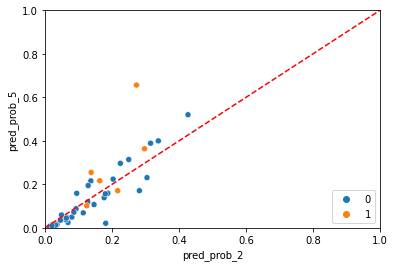

In [141]:
g = sns.scatterplot(data=results, x="pred_prob_2", y="pred_prob_5", hue = "unfavorable")
plt.legend(loc='lower right')
g.set(ylim=(0, 1), xlim=(0,1))
g.plot([0,1], [0,1], "r--")

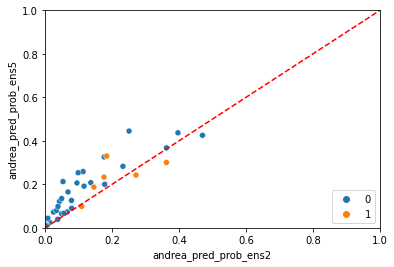

In [142]:
g = sns.scatterplot(data=results, x="andrea_pred_prob_ens2", y="andrea_pred_prob_ens5", hue = "unfavorable")
plt.legend(loc='lower right')
g.set(ylim=(0, 1), xlim=(0,1))
g.plot([0,1], [0,1], "r--")

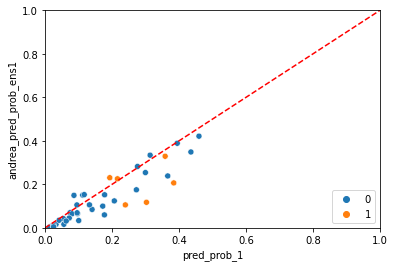

In [143]:
g = sns.scatterplot(data=results, x="pred_prob_1", y="andrea_pred_prob_ens1", hue = "unfavorable")
plt.legend(loc='lower right')
g.set(ylim=(0, 1), xlim=(0,1))
g.plot([0,1], [0,1], "r--")